In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

In [2]:
# Load MNIST data
def load_mnist_data():
    train_images = idx2numpy.convert_from_file('train-images-idx3-ubyte')
    train_labels = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
    test_images = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
    test_labels = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')
    return (train_images.reshape(train_images.shape[0], -1) / 255, train_labels), \
           (test_images.reshape(test_images.shape[0], -1) / 255, test_labels)


(train_images, train_labels), (test_images, test_labels) = load_mnist_data()

In [3]:
# Activation functions
def ReLU(x):
    return np.maximum(x, 0)

def ReLU_derivative(x):
    return np.where(x > 0, 1, 0)


def softmax(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)
    exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


# Initialize parameters with Xavier initialization
def init_params(size):
    return np.random.randn(*size) * np.sqrt(2.0 / np.sum(size))

# One hot encoding
def one_hot(y):
    one_hot_y = np.zeros((y.size, y.max() + 1))
    one_hot_y[np.arange(y.size), y] = 1
    return one_hot_y

# Forward pass
def forward(xb, params):
    Z1 = xb @ params['w1'] + params['b1']
    A1 = ReLU(Z1)
    Z2 = A1 @ params['w2'] + params['b2']
    A2 = ReLU(Z2)
    Z3 = A2 @ params['w3'] + params['b3']
    A3 = softmax(Z3)
    return A3, A2, A1

# Cross-entropy loss with L2 regularization
def cross_entropy_loss_with_l2(res, y, params, l2_penalty):
    one_hot_y = one_hot(y)
    cross_entropy = -np.sum(one_hot_y * np.log(res + 1e-6)) / len(y)
    l2_reg = 0.5 * l2_penalty * (np.sum(np.square(params['w1'])) +
                                 np.sum(np.square(params['w2'])) +
                                 np.sum(np.square(params['w3'])))
    return cross_entropy + l2_reg

# Backpropagation with L2 regularization
def back_prop_with_l2(x, y, res, params, l2_penalty, l2, l1):
    grads = {}
    m = x.shape[0]
    d_loss = res - one_hot(y)  
    grads['w3'] = 1 / m * (l2.T @ d_loss + l2_penalty * params['w3'])
    grads['b3'] = 1 / m * np.sum(d_loss, axis=0)

    d_l2 = ReLU_derivative(l2) * (d_loss @ params['w3'].T)
    grads['w2'] = 1 / m * (l1.T @ d_l2 + l2_penalty * params['w2'])
    grads['b2'] = 1 / m * np.sum(d_l2, axis=0)

    d_l1 = ReLU_derivative(l1) * (d_l2 @ params['w2'].T)
    grads['w1'] = 1 / m * (x.T @ d_l1 + l2_penalty * params['w1'])
    grads['b1'] = 1 / m * np.sum(d_l1, axis=0)

    return grads

# Update parameters
def update_params(params, grads, lr):
    for key in params.keys():
        params[key] -= lr * grads[key]
    return params

# Accuracy calculation
def accuracy(res, y):
    return np.mean(np.argmax(res, axis=1) == y)

# Create a random batch of data
def create_batch(data, data_y, batch_size):
    batch_indices = np.random.choice(data[0].shape[0], batch_size, replace=False)
    xb, yb = data[0][batch_indices], data_y[batch_indices]
    return xb, yb

def create_params(hidden_size=30):
    params = {}
    params['w1'] = init_params((28*28, hidden_size))
    params['b1'] = init_params((hidden_size,))
    params['w2'] = init_params((hidden_size, 10))
    params['b2'] = init_params((10,))
    params['w3'] = init_params((10, 10))
    params['b3'] = init_params((10,))
    return params

In [81]:
def training(data, data_y, test_data, test_data_y, epochs, hidden_layer_sizes, batch_size=256, lr=0.1, l2_penalty=0.001, save_path=None):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_test_accuracy = 0.0
    best_params = None
    params = create_params(hidden_layer_sizes)
    
    for ep in range(epochs + 1):
        for batch in range(int(data[0].shape[0] / batch_size) + 1):
            # Create a random batch of data
            xb, yb = create_batch(data, data_y, batch_size)
            res, l2, l1 = forward(xb, params)
            grads = back_prop_with_l2(xb, yb, res, params, l2_penalty, l2, l1)
            params = update_params(params, grads, lr)
        
        if ep % 1 == 0:
            # Calculate for training set
            res_train, _, _ = forward(data[0], params)
            train_loss = cross_entropy_loss_with_l2(res_train, data_y, params, l2_penalty)
            train_accuracy = accuracy(res_train, data_y)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            # Calculate for test set
            res_test, _, _ = forward(test_data[0], params)
            test_loss = cross_entropy_loss_with_l2(res_test, test_data_y, params, l2_penalty)
            test_accuracy = accuracy(res_test, test_data_y)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            
            print(f"Epoch: {ep}/{epochs}")
            print(f"Training Loss: {train_loss}")
            print(f"Training Accuracy: {train_accuracy}")
            print(f"Test Loss: {test_loss}")
            print(f"Test Accuracy: {test_accuracy}")
            print("----------------------------------------")
            
            # Check if current test accuracy is better than the best seen so far
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                best_params = params
                # Save the parameters of the best model if save_path is provided
                if save_path:
                    np.savez(save_path, **best_params)
                
    return train_losses, train_accuracies, test_losses, test_accuracies


In [76]:
def train_for_parameter_tuning(train_data, train_labels, val_data, val_labels, epochs, hidden_layer_sizes, batch_size=256, lr=0.1, l2_penalty=0.001):
    best_validation_accuracy = 0.0
    params = create_params(hidden_layer_sizes)
        
    for ep in range(epochs + 1):
        for batch in range(int(train_data.shape[0] / batch_size) + 1):
            # Create a random batch of data
            xb, yb = create_batch((train_data, train_labels), train_labels, batch_size)
            res, l2, l1 = forward(xb, params)
            grads = back_prop_with_l2(xb, yb, res, params, l2_penalty, l2, l1)
            params = update_params(params, grads, lr)

        if ep % 50 == 0:
            res_train, _, _ = forward(train_data, params)
            res_val, _, _ = forward(val_data, params)
            validation_accuracy = accuracy(res_val, val_labels)
            loss = cross_entropy_loss_with_l2(res_train, train_labels, params, l2_penalty)

            print(f"Epoch: {ep}/{epochs}")
            print(f"Loss: {loss}")
            print(f"Training Accuracy: {accuracy(res_train, train_labels)}")
            print(f"Validation Accuracy: {validation_accuracy}")
            print("----------------------------------------")

    return validation_accuracy, loss


In [52]:
def custom_train_validation_split(data, labels, validation_ratio=0.2, shuffle=True, random_state=None):
    data = np.array(data)
    labels = np.array(labels)

    num_samples = len(data)

    if random_state is not None:
        np.random.seed(random_state)

    if shuffle:
        indices = np.random.permutation(num_samples)
        data = data[indices]
        labels = labels[indices]

    num_validation_samples = int(num_samples * validation_ratio)

    # Split the data and labels into training and validation sets
    val_data = data[:num_validation_samples]
    val_labels = labels[:num_validation_samples]
    train_data = data[num_validation_samples:]
    train_labels = labels[num_validation_samples:]

    return train_data, train_labels, val_data, val_labels

# Split the original training dataset into training and validation sets
train_images, train_labels, val_images, val_labels = custom_train_validation_split(train_images, train_labels, validation_ratio=0.2)

In [54]:
# Function for parameter tuning
def parameter_tuning(train_data, train_data_y, test_data, test_data_y, epochs, hidden_layer_sizes, batch_size, lr_values, l2_values):
    results = []

    for lr in lr_values:
        for hidden_size in hidden_layer_sizes:
            for l2_penalty in l2_values:
                print(f"Training with lr={lr}, hidden_size={hidden_size}, l2_penalty={l2_penalty}")
                validation_accuracy, loss = train_for_parameter_tuning(train_data, train_data_y, test_data, test_data_y, epochs, hidden_size, batch_size, lr, l2_penalty)
                results.append({
                    'lr': lr,
                    'hidden_size': hidden_size,
                    'l2_penalty': l2_penalty,
                    'validation_accuracy': validation_accuracy,
                    'loss': loss
                })
    
    return results

In [55]:
# Perform parameter tuning
lr_values = [0.001, 0.01, 0.05]
hidden_layer_sizes = [20, 40]
l2_values = [0.001, 0.01, 0.05]

results = parameter_tuning(train_images, train_labels, val_images, val_labels, epochs = 100, lr_values = lr_values, hidden_layer_sizes = hidden_layer_sizes, l2_values=l2_values, batch_size = 256)

Training with lr=0.001, hidden_size=20, l2_penalty=0.001
Epoch: 0/100
Loss: 2.4818700211907228
Training Accuracy: 0.11812337239583333
Validation Accuracy: 0.11702473958333333
----------------------------------------
Epoch: 50/100
Loss: 1.6215276599568353
Training Accuracy: 0.4599202473958333
Validation Accuracy: 0.45361328125
----------------------------------------
Epoch: 100/100
Loss: 1.1980484831120484
Training Accuracy: 0.5496826171875
Validation Accuracy: 0.5362955729166666
----------------------------------------
Training with lr=0.001, hidden_size=20, l2_penalty=0.01
Epoch: 0/100
Loss: 2.607813548880716
Training Accuracy: 0.18436686197916666
Validation Accuracy: 0.18798828125
----------------------------------------
Epoch: 50/100
Loss: 1.3369335723061913
Training Accuracy: 0.6609700520833334
Validation Accuracy: 0.6624348958333334
----------------------------------------
Epoch: 100/100
Loss: 1.1324794271499932
Training Accuracy: 0.72412109375
Validation Accuracy: 0.7194010416666

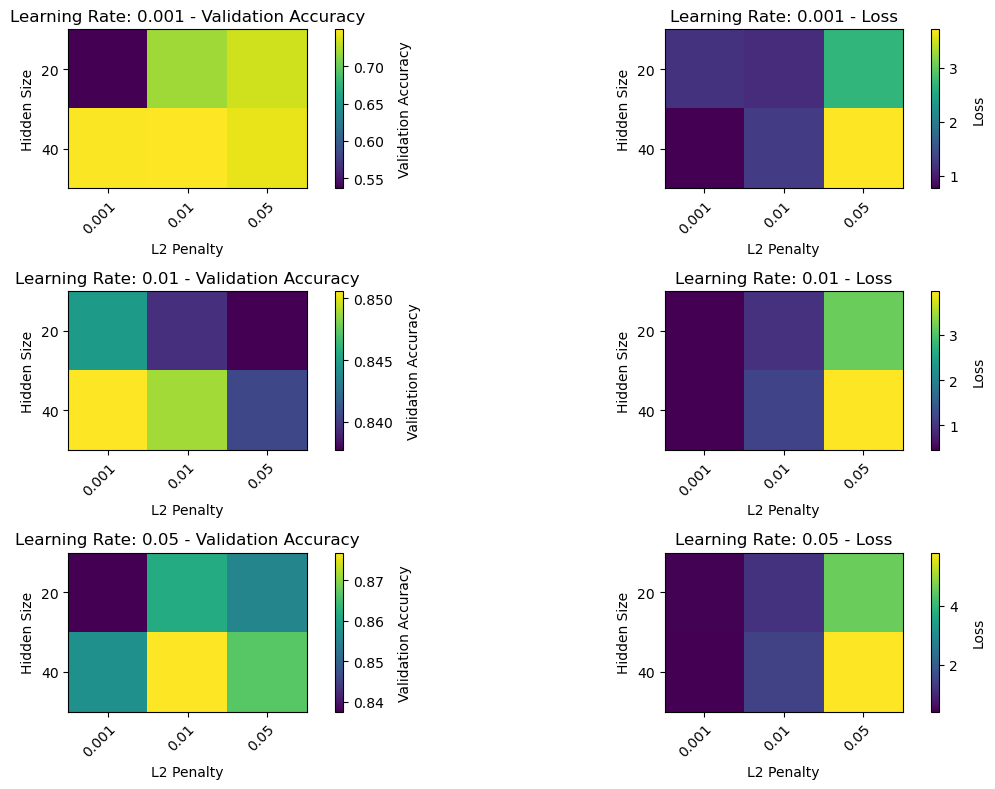

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_heatmap(results):
    lr_values = sorted(set(result['lr'] for result in results))
    hidden_sizes = sorted(set(result['hidden_size'] for result in results))
    l2_values = sorted(set(result['l2_penalty'] for result in results))

    fig, axs = plt.subplots(len(lr_values), 2, figsize=(12, 8))

    for k, lr in enumerate(lr_values):
        accuracies = np.zeros((len(hidden_sizes), len(l2_values)))
        losses = np.zeros((len(hidden_sizes), len(l2_values)))
        for i, hidden_size in enumerate(hidden_sizes):
            for j, l2_penalty in enumerate(l2_values):
                validation_accuracy = [result['validation_accuracy'] for result in results if result['hidden_size'] == hidden_size and result['l2_penalty'] == l2_penalty and result['lr'] == lr]
                accuracies[i, j] = max(validation_accuracy, default=np.nan)
                loss = [result['loss'] for result in results if result['hidden_size'] == hidden_size and result['l2_penalty'] == l2_penalty and result['lr'] == lr]
                losses[i, j] = min(loss, default=np.nan)

        # Plot accuracy heatmap
        im1 = axs[k, 0].imshow(accuracies, cmap='viridis')
        axs[k, 0].set_title(f'Learning Rate: {lr} - Validation Accuracy')
        axs[k, 0].set_xlabel('L2 Penalty')
        axs[k, 0].set_ylabel('Hidden Size')
        axs[k, 0].set_xticks(np.arange(len(l2_values)))
        axs[k, 0].set_yticks(np.arange(len(hidden_sizes)))
        axs[k, 0].set_xticklabels([f"{l2}" for l2 in l2_values])
        axs[k, 0].set_yticklabels([f"{hidden}" for hidden in hidden_sizes])
        plt.setp(axs[k, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        cbar1 = axs[k, 0].figure.colorbar(im1, ax=axs[k, 0])
        cbar1.set_label('Validation Accuracy', rotation=90, labelpad=10)

        # Plot loss heatmap
        im2 = axs[k, 1].imshow(losses, cmap='viridis')
        axs[k, 1].set_title(f'Learning Rate: {lr} - Loss')
        axs[k, 1].set_xlabel('L2 Penalty')
        axs[k, 1].set_ylabel('Hidden Size')
        axs[k, 1].set_xticks(np.arange(len(l2_values)))
        axs[k, 1].set_yticks(np.arange(len(hidden_sizes)))
        axs[k, 1].set_xticklabels([f"{l2}" for l2 in l2_values])
        axs[k, 1].set_yticklabels([f"{hidden}" for hidden in hidden_sizes])
        plt.setp(axs[k, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        cbar2 = axs[k, 1].figure.colorbar(im2, ax=axs[k, 1])
        cbar2.set_label('Loss', rotation=90, labelpad=10)

    plt.tight_layout()
    plt.show()

plot_results_heatmap(results)


In [69]:
def find_best_parameters(results):
    best_accuracy = 0
    best_loss = float('inf')
    best_parameters = None

    for result in results:
        accuracy = result['validation_accuracy']
        loss = result['loss']

        if accuracy > best_accuracy or (accuracy == best_accuracy and loss < best_loss):
            best_accuracy = accuracy
            best_loss = loss
            best_parameters = result

    return best_parameters

best_parameters = find_best_parameters(results)
print("Best parameters:")
print(best_parameters)


Best parameters:
{'lr': 0.05, 'hidden_size': 40, 'l2_penalty': 0.01, 'validation_accuracy': 0.8767903645833334, 'loss': 1.4687095695069652}


In [82]:
# Get the best hyperparameters
best_lr = best_parameters['lr']
best_hidden_size = best_parameters['hidden_size']
best_l2_penalty = best_parameters['l2_penalty']

# Training
train_losses, train_accuracies, test_losses, test_accuracies = training((train_images, train_labels), train_labels, (test_images, test_labels), test_labels, epochs=100, hidden_layer_sizes = best_hidden_size, batch_size=256, lr=best_lr, l2_penalty=best_l2_penalty, save_path="final_model_params.npz")

Epoch: 0/100
Training Loss: 1.7775450764557335
Training Accuracy: 0.6036783854166666
Test Loss: 1.7913397291387079
Test Accuracy: 0.5948
----------------------------------------
Epoch: 1/100
Training Loss: 1.3854662014370223
Training Accuracy: 0.7405192057291666
Test Loss: 1.407025879804663
Test Accuracy: 0.7329
----------------------------------------
Epoch: 2/100
Training Loss: 1.273940087948258
Training Accuracy: 0.7721761067708334
Test Loss: 1.3010398593323824
Test Accuracy: 0.7589
----------------------------------------
Epoch: 3/100
Training Loss: 1.2561737054127353
Training Accuracy: 0.7755126953125
Test Loss: 1.2900045465553558
Test Accuracy: 0.7602
----------------------------------------
Epoch: 4/100
Training Loss: 1.2023791762034892
Training Accuracy: 0.8020426432291666
Test Loss: 1.2367525845081628
Test Accuracy: 0.7881
----------------------------------------
Epoch: 5/100
Training Loss: 1.1991884912881425
Training Accuracy: 0.8028157552083334
Test Loss: 1.2338729980361078


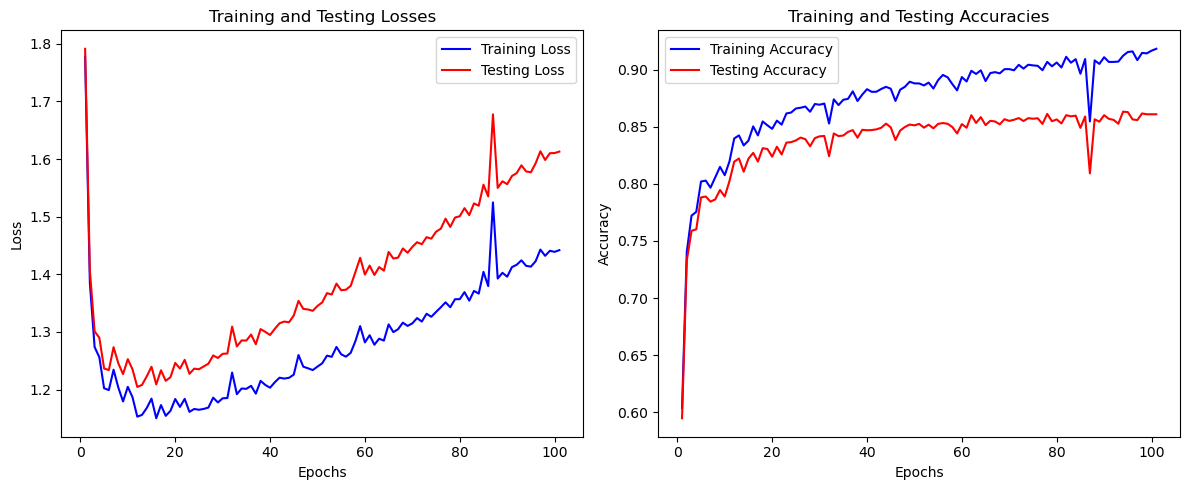

In [83]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and testing losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
    plt.title('Training and Testing Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and testing accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'r-', label='Testing Accuracy')
    plt.title('Training and Testing Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)


In [84]:
# Load the parameters from the saved file
saved_params = np.load("final_model_params.npz")

# Extract the parameters from the saved file
final_params = {
    'w1': saved_params['w1'],
    'b1': saved_params['b1'],
    'w2': saved_params['w2'],
    'b2': saved_params['b2'],
    'w3': saved_params['w3'],
    'b3': saved_params['b3']
}

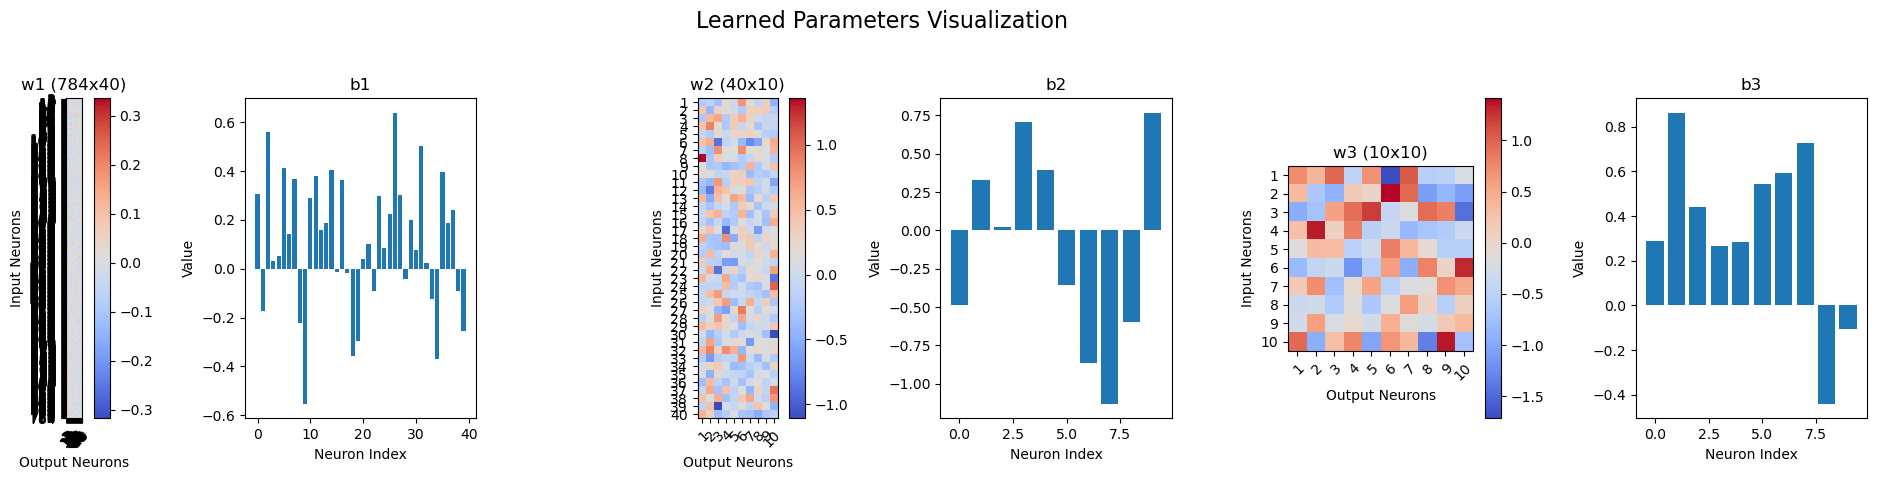

In [85]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_parameters(params):
    fig, axes = plt.subplots(1, len(params), figsize=(20, 5))
    fig.suptitle('Learned Parameters Visualization', fontsize=16)
    
    for i, (param_name, param_value) in enumerate(params.items()):
        ax = axes[i]
        if 'w' in param_name:
            ax.imshow(param_value, cmap='coolwarm', aspect='auto')
            ax.set_title(f'{param_name} ({param_value.shape[0]}x{param_value.shape[1]})')
            ax.set_xlabel('Output Neurons')
            ax.set_ylabel('Input Neurons')
            ax.set_xticks(np.arange(param_value.shape[1]))
            ax.set_yticks(np.arange(param_value.shape[0]))
            ax.set_xticklabels(np.arange(1, param_value.shape[1] + 1))
            ax.set_yticklabels(np.arange(1, param_value.shape[0] + 1))
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            plt.colorbar(ax.imshow(param_value, cmap='coolwarm'), ax=ax)
        else:
            # Plot biases directly
            ax.bar(range(len(param_value)), param_value)
            ax.set_title(f'{param_name}')
            ax.set_ylabel('Value')
            ax.set_xlabel('Neuron Index')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

visualize_parameters(final_params)
